In [1]:
!pip install -q yfinance
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, InputSpec,  Dense, LSTM, Dropout, ConvLSTM2D, Conv2D, BatchNormalization, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

stock_data = {}

stock_data["STM"] = yf.download("STM", start, end)

STM = stock_data["STM"]

[*********************100%%**********************]  1 of 1 completed


In [4]:
STM["Company"] = "STM"
print(STM.head(10))
print(STM.describe())
print(STM.info())

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2004-03-12  24.330000  24.450001  24.059999  24.299999  14.871044  2056000   
2004-03-15  23.690001  23.770000  23.110001  23.270000  14.240697  1736000   
2004-03-16  23.830000  23.879999  23.230000  23.540001  14.405938  1430500   
2004-03-17  23.799999  24.230000  23.760000  24.110001  14.754766  1208400   
2004-03-18  23.790001  23.990000  23.680000  23.900000  14.626245  1082200   
2004-03-19  23.590000  23.719999  23.150000  23.160000  14.173388  1394800   
2004-03-22  23.030001  23.110001  22.770000  22.980000  14.063225  1007400   
2004-03-23  23.230000  23.230000  22.650000  22.760000  13.928594  1471200   
2004-03-24  22.400000  22.740000  22.270000  22.580000  13.818439  2570300   
2004-03-25  23.000000  23.450001  22.969999  23.450001  14.350859  1835400   

           Company  
Date                
2004-03-12     STM  


Viewing History of Closing Price

Text(0.5, 1.0, 'Adj Closing Price STMicroelectronics in 30 years')

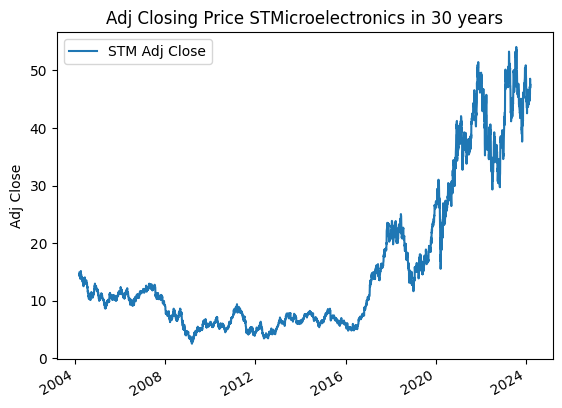

In [5]:
# # Let's see a historical view of the closing price

STM['Adj Close'].plot(label="STM Adj Close")
plt.legend()

plt.ylabel('Adj Close')
plt.xlabel(None)

plt.title(f"Adj Closing Price STMicroelectronics in 30 years")

Text(0.5, 1.0, 'Adj Closing Price STMicroelectronics in 30 years, with Moving Average')

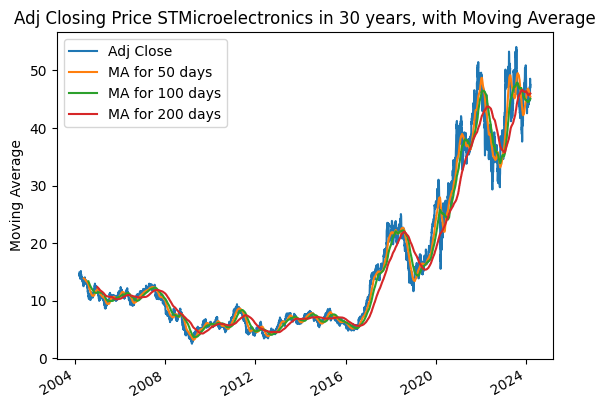

In [6]:
ma_day = [50, 100, 200]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    STM[column_name] = STM['Adj Close'].rolling(ma).mean()


STM[['Adj Close', 'MA for 50 days', 'MA for 100 days', 'MA for 200 days']].plot(label="STM Adj Close")

plt.ylabel('Moving Average')
plt.xlabel(None)

plt.title(f"Adj Closing Price STMicroelectronics in 30 years, with Moving Average")

In [7]:
STM

,Open,High,Low,Close,Adj Close,Volume,Company,MA for 50 days,MA for 100 days,MA for 200 days
Date,,,,,,,,,,
2004-03-12,24.330000,24.450001,24.059999,24.299999,14.871044,2056000,STM,NaN,NaN,NaN
2004-03-15,23.690001,23.770000,23.110001,23.270000,14.240697,1736000,STM,NaN,NaN,NaN
2004-03-16,23.830000,23.879999,23.230000,23.540001,14.405938,1430500,STM,NaN,NaN,NaN
2004-03-17,23.799999,24.230000,23.760000,24.110001,14.754766,1208400,STM,NaN,NaN,NaN
2004-03-18,23.790001,23.990000,23.680000,23.900000,14.626245,1082200,STM,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-03-05,46.220001,46.419998,45.470001,45.849998,45.849998,3468200,STM,45.6928,44.932544,45.945172
2024-03-06,46.220001,47.250000,45.980000,46.860001,46.860001,4194000,STM,45.6252,44.950209,45.957792
2024-03-07,47.450001,49.049999,47.419998,48.570000,48.570000,4504900,STM,45.5942,44.992566,45.976323


In [8]:
# Create a new dataframe with only the 'Close column
data = STM.filter(['Open', 'High',  'Low',  'Close',    'Adj Close',    'Volume'])
# Convert the dataframe to a numpy array
dataset = data.values
look_back = 50
n_features = 1
train_testsplit = 0.8

In [9]:
dataset.shape

(5033, 6)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data.shape

(5033, 6)

In [11]:
type(scaled_data)

numpy.ndarray

In [12]:
# Split the data into x_train and y_train data sets
x_list = []
y_list = []

sos_array = np.full((1, 6), 0)  #-1 is a distinguisherable value outside of the minmax range of 0-1
eos_array = np.full((1, 6), 1)  #2 is a distinguisherable value outside of the minmax range of 0-1

for i in range(look_back, len(scaled_data)-look_back):
    x_list.append(scaled_data[i-look_back:i, :])
    y_list.append(scaled_data[i:i+look_back, :])

x_input = []
y_input = []
y_output = []

for i in x_list:
  i_x_input = np.vstack([sos_array, i])
  x_input.append(i_x_input)

for i in y_list:
  i_y_input = np.vstack([sos_array, i])
  y_input.append(i_y_input)

  i_y_output = np.vstack([i, eos_array])
  y_output.append(i_y_output)

In [13]:
x_input, y_input, y_output = np.array(x_input), np.array(y_input), np.array(y_output)


print(x_input.shape)
print(y_input.shape)
print(y_output.shape)

(4933, 51, 6)
(4933, 51, 6)
(4933, 51, 6)


In [14]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(x_input) * train_testsplit))
# print("training_data_len", training_data_len)

x_train = x_input[:training_data_len, :, :]
y_train_input = y_input[:training_data_len, :, :]
y_train_output = y_output[:training_data_len, :, :]

x_test = x_input[training_data_len:, :, :]
y_test_input = y_input[training_data_len:, :, :]
y_test_output = y_output[training_data_len:, :, :]

print("x_train's shape",  x_train.shape)
print("y_train_input's shape", y_train_input.shape)
print("y_train_output's shape", y_train_output.shape)

print("x_test's shape",  x_test.shape)
print("y_test_input's shape", y_test_input.shape)
print("y_test_output's shape", y_test_output.shape)

x_train's shape (3947, 51, 6)
y_train_input's shape (3947, 51, 6)
y_train_output's shape (3947, 51, 6)
x_test's shape (986, 51, 6)
y_test_input's shape (986, 51, 6)
y_test_output's shape (986, 51, 6)


In [15]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2],  1, 1))
y_train_input = np.reshape(y_train_input, (y_train_input.shape[0], y_train_input.shape[1], y_train_input.shape[2], 1, 1))
y_train_output = np.reshape(y_train_output, (y_train_output.shape[0], y_train_output.shape[1], y_train_output.shape[2], 1, 1))


print(x_train.shape)
print(y_train_input.shape)
print(y_train_output.shape)

(3947, 51, 6, 1, 1)
(3947, 51, 6, 1, 1)
(3947, 51, 6, 1, 1)


In [16]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2],  1, 1))
y_test_input = np.reshape(y_test_input, (y_test_input.shape[0], y_test_input.shape[1], y_test_input.shape[2], 1, 1))
y_test_output = np.reshape(y_test_output, (y_test_output.shape[0], y_test_output.shape[1], y_test_output.shape[2], 1, 1))


print(x_test.shape)
print(y_test_input.shape)
print(y_test_output.shape)

(986, 51, 6, 1, 1)
(986, 51, 6, 1, 1)
(986, 51, 6, 1, 1)


In [17]:
# make sure we do softmax over the time axis
# expected shape for translation is N x T x D
# expected shape for attention is N x T x V x 1 x 1, since will will be computing the cosine similiarity between the output of both encoder and decoder

def softmax_over_time(x):
  assert(K.ndim(x) > 4)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [18]:
##Keras RepearVector is only possible to repeat and transform Tensor from 2D to 3D. Hence a custom one is created here to transform 4D to 5D. Hehe yay.=)

class RepeatVector4D():

    def __init__(self, n=look_back+1, **kwargs):
        self.n = n
        self.input_spec = [InputSpec(ndim=3)]
        super(RepeatVector4D, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.n, input_shape[1], input_shape[2])

    def call(self, x, mask=None):
        x = K.expand_dims(x, 1)
        pattern = K.stack([1, self.n, 1, 1, 1])  #The repeat happens along the T element
        return K.tile(x, pattern)

In [19]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector4D(x_train.shape[1])
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=(1, 1)) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, 6, 1, 64 * 2)  #Since it is bidirectional for encoder
  # st_1 = s(t-1), shape = (6, 1, 64)                 #s(t-1) states will soon made to be the same length with h, time element wise

  # copy s(t-1) Tx times
  # now shape = (Tx, 6, 1, 64)
  hshape_b = print("H's shape before repeat", h)
  st_1shape_b = print("st1's shape before repeat", st_1)

  st_1 = attn_repeat_layer.call(st_1)

  hshape = print("H's shape after repeat", h)
  st_1shape = print("st1's shape after repeat", st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, 6, 1, 64 * 2 +64)
  x = attn_concat_layer([h, st_1])
  print("Shape of X", x.shape)

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)
  print("Shape of alphas", alphas.shape)

  # h_reshaped = tf.keras.layers.Reshape((51, 6, 128))(h)
  # print("h_reshaped",  h_reshaped)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context_ = alphas*h
  context = K.expand_dims(tf.keras.backend.sum(context_, axis = 1), 1)
  print("Context shape",  context.shape) #Contect vector must be the same dimention as the h, which is the output_shape from

  return context

In [20]:
##########################
##### build the model #####
filters = 64

encoder_inputs_placeholder = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4]))
encoder = Bidirectional(ConvLSTM2D(filters=filters, kernel_size=(1, 3),padding='same', return_state=True, return_sequences=True))# dropout=0.5 # dropout not available on gpu) #Since only the last state is needed,we don' specify the return seq, thus return_deq=False.
               #https://stackoverflow.com/questions/55296013/why-set-return-sequences-true-and-stateful-true-for-tf-keras-layers-lstm

encoder_outputs, h, co ,_ , _ = encoder(encoder_inputs_placeholder)

# # keep only the states to pass into decoder
# encoder_states = [h, c]

# Set up the decoder, using [h, c] as initial state.
# decoder_inputs_placeholder = Input(shape=(y_train_input.shape[1], y_train_input.shape[2], y_train_input.shape[3], filters*2 + 1))
decoder_inputs_placeholder_teaforcing = Input(shape=(y_train_input.shape[1], y_train_input.shape[2], y_train_input.shape[3], y_train_input.shape[4]))
#This decoder input needs to be separated since the decoder input's shape used for teacher forcing is (None, 1,6,1,1),
# but when it get concatenated and goes into the loop of length Ty, the shape is (None, 1,6,1,129). Hence you can't use the same placeholder. =))

# since the decoder is a "to-many" model we want to have return_sequences=True
decoder_lstm = ConvLSTM2D(filters=filters, kernel_size=(1, 3),padding='same', return_state=True, return_sequences=True) # dropout=0.5 # dropout not available on gpu)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs_placeholder, initial_state=encoder_states)
# decoder_outputs = decoder_lstm(decoder_inputs_placeholder)
decoder_dense = Dense(1, activation='relu')
# initial_s = Input(shape=(6, 1, filters), name='s0')
# initial_c = Input(shape=(6, 1, filters), name='c0')
context_last_word_concat_layer = Concatenate(axis = -1)


# # Create the model object
# Unlike previous seq2seq, we cannot get the output all in one step
# Instead we need to do Ty steps and in each of those steps, we need to consider all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = h
c = co

# collect outputs in a list at first
outputs_ = []
for t in range(y_train_input.shape[1]): # Ty times
  # get the context using attention
  # context = one_step_attention(encoder_outputs[0], s)
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_placeholder_teaforcing)


  # print("Shape of xt", xt)

  # combine
  decoder_lstm_input = context_last_word_concat_layer([context, xt])
  # print("Shape of decoder_lstm_input", decoder_lstm_input)

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # print("Shape of o, s, c", o.shape, s.shape, c.shape)
  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs_.append(decoder_outputs)
  # print("Shape of output", outputs_)


# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

H's shape before repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 128), dtype=tf.float32, name=None), name='bidirectional/concat:0', description="created by layer 'bidirectional'")
st1's shape before repeat KerasTensor(type_spec=TensorSpec(shape=(None, 6, 1, 64), dtype=tf.float32, name=None), name='bidirectional/forward_conv_lstm2d/while:4', description="created by layer 'bidirectional'")
H's shape after repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 128), dtype=tf.float32, name=None), name='bidirectional/concat:0', description="created by layer 'bidirectional'")
st1's shape after repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 64), dtype=tf.float32, name=None), name='tf.tile/Tile:0', description="created by layer 'tf.tile'")
Shape of X (None, 51, 6, 1, 192)
Shape of alphas (None, 51, 6, 1, 1)
Context shape (None, 1, 6, 1, 128)
H's shape before repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 128), dtype=tf.float32, name=None),

In [21]:
def stack_and_transpose(x):
  # x is a list of length T, and in each each element is a batch_size x 1 (each time stamp) x no of variable x 1 X 1; shape=(None, 1, 6, 1, 1)
  print("x.shape", x)
  x2 = tf.concat([i for i in x], axis=1) # is now T x batch_size x output_vocab_size tensor shape=(None, T, 6, 1, 1)
  # x = K.stack(x, axis=1)
  print("x2.shape", x2.shape)
  # x2 = K.permute_dimensions(x, pattern=(1, 0, 2, 3, 4, 5)) # shape=(None, 1, 6, 1, 1)

  return x2

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs_)

x.shape [<tf.Tensor 'Placeholder:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_1:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_3:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_4:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_5:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_6:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_7:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_8:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_9:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_10:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_11:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_12:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'Placeholder_13:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tenso

In [22]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder_teaforcing],
  outputs=outputs
)

In [23]:
# compile the model
model.compile(optimizer='adam', loss='mae', metrics='mae')

In [24]:
print("x_train's shape", x_train.shape)
print("y_train input's shape",y_train_input.shape)
print("y_train output's shape",y_train_output.shape)

x_train's shape (3947, 51, 6, 1, 1)
y_train input's shape (3947, 51, 6, 1, 1)
y_train output's shape (3947, 51, 6, 1, 1)


In [25]:
BATCH_SIZE = 1
EPOCHS = 2

# z = np.zeros((x_train.shape[0], 6,1,filters)) # initial [s, c]
r = model.fit([x_train, y_train_input], y_train_output, batch_size=BATCH_SIZE, epochs=EPOCHS,  verbose=1)

Epoch 1/2
x.shape [<tf.Tensor 'model/dense_2/Relu:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_1:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_2:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_3:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_4:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_5:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_6:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_7:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_8:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_9:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_10:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_11:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_12:0' shape=(1, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/

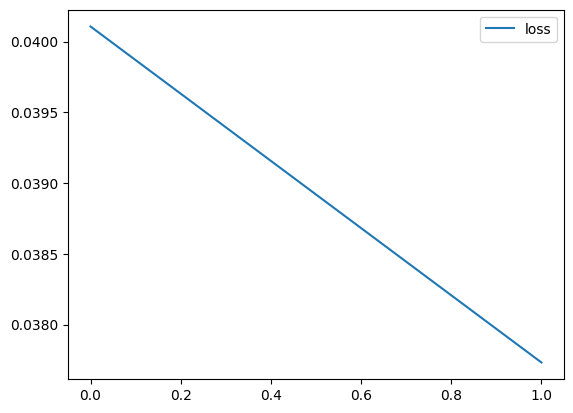

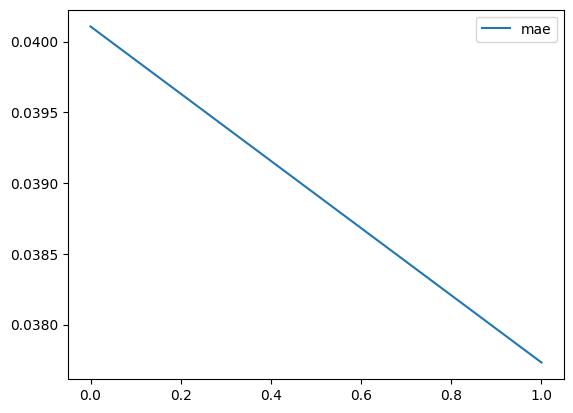

In [26]:

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['mae'], label='mae')
plt.legend()
plt.show()

In [27]:
def error_calculator(predictions, y_test_output):

    predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[1],predictions.shape[2]))
    y_test_output = np.reshape(y_test_output, (y_test_output.shape[0], y_test_output.shape[1],y_test_output.shape[2]))

    prediction_rev_scaled = []
    y_test_rev_scaled = []

    for i in predictions:
      i_prediction = scaler.inverse_transform(i)
      prediction_rev_scaled.append(i_prediction)

    for i in y_test_output:
      i_y_test = scaler.inverse_transform(i)
      y_test_rev_scaled.append(i_y_test)

    prediction_rev_scaled = np.array(prediction_rev_scaled)
    y_test_rev_scaled = np.array(y_test_rev_scaled)


    # print("Prediction shape", prediction_rev_scaled.shape)
    # print("y_test shape", y_test_rev_scaled.shape)
    # print(predictions)
    # print(y_test)

    # Get the rmse, mae and mape
    rmse = np.sqrt(np.mean(np.square(prediction_rev_scaled - y_test_rev_scaled), axis=(0,1)))
    print("rmse is" , rmse)
    mae = K.mean(K.abs(prediction_rev_scaled - y_test_rev_scaled), axis=(0,1)).numpy()
    print("mae is" , mae)
    mape = (K.mean(K.abs(prediction_rev_scaled - y_test_rev_scaled)/K.maximum(K.abs(y_test_rev_scaled), K.epsilon()), axis=(0,1))*100).numpy()
    print("mape is" , mape)

    return prediction_rev_scaled, y_test_rev_scaled

To show the train MAE after reversed *scaled*

In [28]:
# Reshape the data
print("x_train", x_train.shape)
# z1 = np.zeros((x_train.shape[0], 6,1,filters))
# Get the models predicted price values
predictions = model.predict([x_train, y_train_input])
prediction_rev_scaled, y_train_rev_scaled = error_calculator(predictions, y_train_output)

x_train (3947, 51, 6, 1, 1)
x.shape [<tf.Tensor 'model/dense_2/Relu:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_1:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_2:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_3:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_4:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_5:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_6:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_7:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_8:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_9:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_10:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_11:0' shape=(None, 1, 6, 1, 1) dtype=float32>, <tf.Tensor 'model/dense_2/Relu_12:0' sh

To show the test MAE after reversed scaled

In [29]:
# Reshape the data
print("x_test", x_test.shape)
z1 = np.zeros((x_test.shape[0], 6,1,filters))
# Get the models predicted price values
predictions = model.predict([x_test, y_test_input])
prediction_rev_scaled, y_test_rev_scaled = error_calculator(predictions, y_test_output)

x_test (986, 51, 6, 1, 1)
31/31 [==============================] - 9s 286ms/step
rmse is [6.95693915e+00 6.99016722e+00 6.88962181e+00 6.95920700e+00
 7.07866805e+00 2.39265763e+06]
mae is [5.64642368e+00 5.69928847e+00 5.58710428e+00 5.64706940e+00
 5.74901586e+00 1.34350904e+06]
mape is [14.29521191 14.28434943 14.33636788 14.27396744 14.70970666 44.09801165]


(0.0, 34.68448224067688)

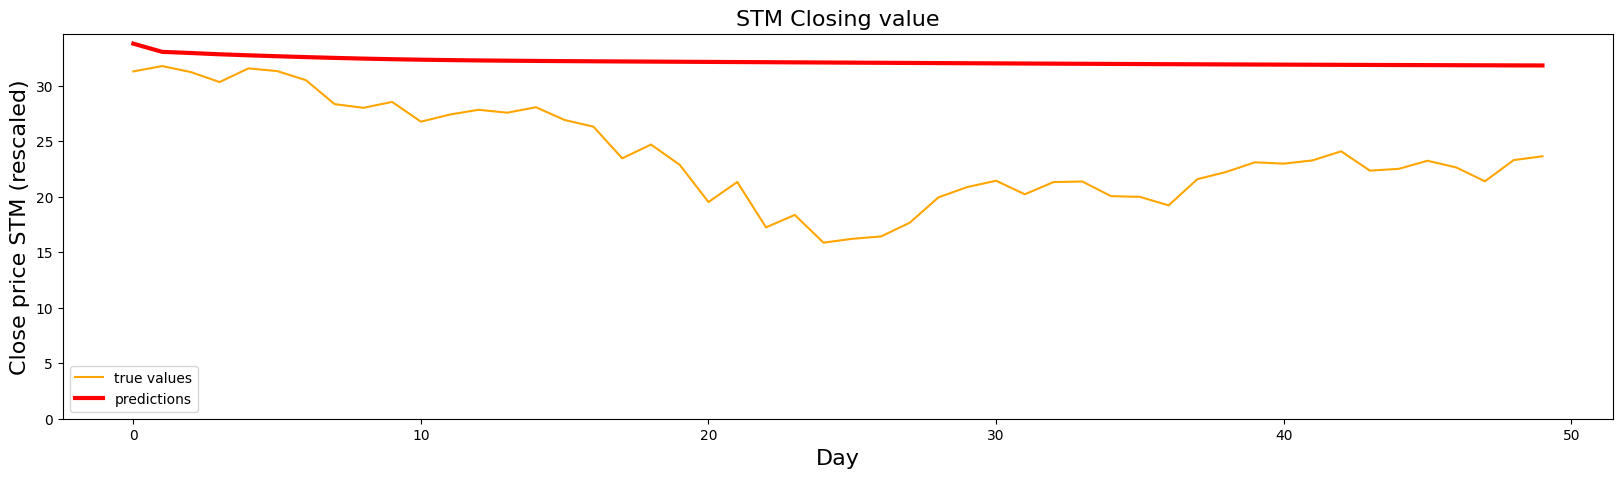

In [30]:
plt.figure(figsize=(20,5))
plt.plot(y_test_rev_scaled[10,:-1,3], c='orange',label='true values')
plt.plot(prediction_rev_scaled[10,:-1,3], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("Day", fontsize=16)
plt.ylabel("Close price STM (rescaled)", fontsize=16)
plt.title("STM Closing value", fontsize=16);
plt.ylim(0)

(0.0, 7705655.0)

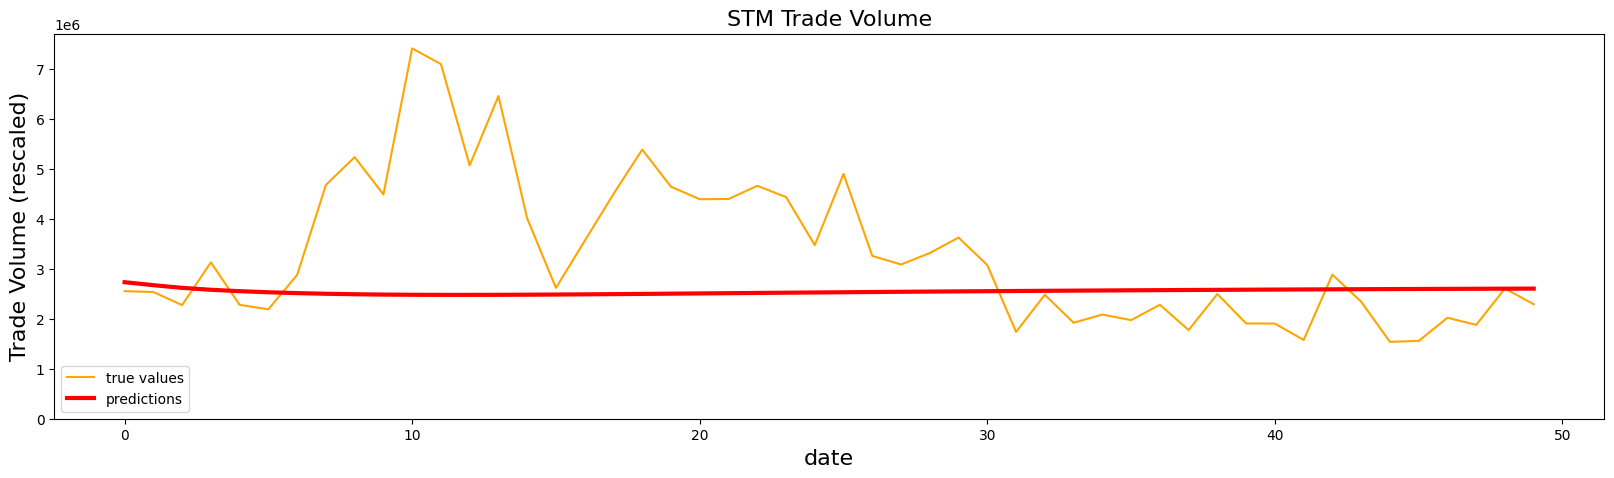

In [31]:
plt.figure(figsize=(20,5))
plt.plot(y_test_rev_scaled[10,:-1,5], c='orange',label='true values')
plt.plot(prediction_rev_scaled[10,:-1,5], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Trade Volume (rescaled)", fontsize=16)
plt.title("STM Trade Volume", fontsize=16);
plt.ylim(0)

In [32]:
##### Make predictions #####
#  Another model needs to be created to take in the previous RNN state and previous word as input and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(inputs = [encoder_inputs_placeholder], outputs = [encoder_outputs, h, co] )

decoder_state_input_s = Input(shape=(6, 1, filters))
decoder_state_input_c = Input(shape=(6, 1, filters))
# decoder_states_inputs = [decoder_state_input_s, decoder_state_input_c]

encoder_outputs_as_input = Input(shape=(look_back + 1, 6, 1, filters*2)) #Unlike the training model, please remember to specify the len of Time here, or else there won be attention weight over time =)
decoder_inputs_single = Input(shape=(1, y_train_input.shape[2], y_train_input.shape[3], y_train_input.shape[4]))

# no need to loop over attention steps like last time in where we breakup the decoder input into Ty size.
# since this time because there is the placeholder only have 1 time stamp, there is no loop over the context vector here.
# attn_repeat_layer = RepeatVector4D(1)
# encoder_outputs_as_input = attn_repeat_layer.call(encoder_outputs_as_input_) #need to be resized to follow shape=(None, 1, 6, 1, 64)


context = one_step_attention(encoder_outputs_as_input, decoder_state_input_s)


# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single])

# this time, we want to keep the states too, to be output by our sampling model
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[decoder_state_input_s , decoder_state_input_c])

# decoder_states = [h, c]

decoder_outputs = decoder_dense(o)


# create the model object
decoder_model = Model(inputs =[encoder_outputs_as_input, decoder_inputs_single, decoder_state_input_s, decoder_state_input_c],   outputs = [decoder_outputs, s, c])

H's shape before repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 128), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
st1's shape before repeat KerasTensor(type_spec=TensorSpec(shape=(None, 6, 1, 64), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
H's shape after repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 128), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
st1's shape after repeat KerasTensor(type_spec=TensorSpec(shape=(None, 51, 6, 1, 64), dtype=tf.float32, name=None), name='tf.tile_51/Tile:0', description="created by layer 'tf.tile_51'")
Shape of X (None, 51, 6, 1, 192)
Shape of alphas (None, 51, 6, 1, 1)
Context shape (None, 1, 6, 1, 128)


In [33]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 51, 6, 1, 1)]     0         
                                                                 
 bidirectional (Bidirection  [(None, 51, 6, 1, 128),   100352    
 al)                          (None, 6, 1, 64),                  
                              (None, 6, 1, 64),                  
                              (None, 6, 1, 64),                  
                              (None, 6, 1, 64)]                  
                                                                 
Total params: 100352 (392.00 KB)
Trainable params: 100352 (392.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 6, 1, 64)]           0         []                            
                                                                                                  
 tf.expand_dims_102 (TFOpLa  (None, 1, 6, 1, 64)          0         ['input_3[0][0]']             
 mbda)                                                                                            
                                                                                                  
 input_5 (InputLayer)        [(None, 51, 6, 1, 128)]      0         []                            
                                                                                                  
 tf.tile_51 (TFOpLambda)     (None, 51, 6, 1, 64)         0         ['tf.expand_dims_102[0][

In [35]:
def decode_sequence(input_seq):

  # Encode the input as state vectors.
  states_value,s,c = encoder_model.predict(input_seq)
  # h_states_value = np.array(h)
  # c_states_value = np.array(c)
  # print(h_states_value.shape)
  # print(c_states_value.shape)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, 6, 1, 1))
  target_seq[0, 0, :, 0, 0] = 0
  # print(target_seq)


    # Create the translation
  output_sentence = []
  # s = np.zeros((6,1,filters)) # initial [s, c]
  # c = np.zeros((6,1,filters)) # initial [s, c]


  for _ in range(y_test_output.shape[1]):
    output_value, s, c = decoder_model.predict([target_seq , states_value, s, c])


    for each in output_value:

      if output_value.any() > 0:
        # print("output_value", output_value)
        output_value2append = np.reshape(output_value, (6,1,1))
        output_sentence.append(output_value2append)

      # print("Target seq shape" , target_seq.shape)
      # print("Output value shape", output_value.shape)


      # Update the decoder input
      # which is just the word just generated
      target_seq = output_value

      # Update states
      states_value = [s, c]

  return output_sentence

In [36]:
def trend_pred(x_test):
  final_prediction = []

  for each_batch in x_test:
      each_batch = each_batch.reshape(1, x_test.shape[1], x_test.shape[2], x_test.shape[3], x_test.shape[4])

      # Encode the input to get initial states
      states_value,s,c = encoder_model.predict(each_batch)
      # print("states_value", states_value)

      # Initialize the target sequence with zeros

      target_seq = each_batch[0,0,:,0,0].reshape(1, 1, 6, 1, 1)
      # print("target_seq shape", target_seq.shape)
      # target_seq = np.full((1, 1, 6, 1, 1), 0)
      # target_seq[0, 0, :, 0, 0] = 0

      output_sentence = []

      # Initial states for the decoder
      # s = np.zeros((1, 6, 1, 64))
      # c = np.zeros((1, 6, 1, 64))

      for _ in range(y_test_output.shape[1]):
          # Predict next word and update states
          output_value, s, c = decoder_model.predict([states_value, target_seq, s, c])

          # Append the predicted word to the output sentence
          # print("output_value", output_value)
          output_sentence.append(output_value)

          # Update the target sequence with the predicted word
          target_seq = output_value

      final_prediction.append(output_sentence)

  final_prediction = np.array(final_prediction)

  return final_prediction

In [37]:
final_prediction_ = trend_pred(x_test)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step


In [38]:
print(final_prediction_.shape)
print(y_test_output.shape)

(986, 51, 1, 1, 6, 1, 1)
(986, 51, 6, 1, 1)


In [39]:
final_prediction = final_prediction_.reshape((y_test_output.shape[0], y_test_output.shape[1], y_test_output.shape[2], y_test_output.shape[3], y_test_output.shape[4]))
final_prediction

array([[[[[0.5106523 ]],

         [[0.50467736]],

         [[0.51309216]],

         [[0.51733613]],

         [[0.51799023]],

         [[0.20503902]]],


        [[[0.5528553 ]],

         [[0.54624856]],

         [[0.5556812 ]],

         [[0.5595399 ]],

         [[0.5605034 ]],

         [[0.20256528]]],


        [[[0.5748394 ]],

         [[0.5677697 ]],

         [[0.577946  ]],

         [[0.5816348 ]],

         [[0.5828095 ]],

         [[0.19651812]]],


        ...,


        [[[0.7150194 ]],

         [[0.7083752 ]],

         [[0.718756  ]],

         [[0.7209357 ]],

         [[0.7228735 ]],

         [[0.2507163 ]]],


        [[[0.71542513]],

         [[0.70880145]],

         [[0.7191537 ]],

         [[0.72132343]],

         [[0.723259  ]],

         [[0.25246984]]],


        [[[0.71579117]],

         [[0.7091872 ]],

         [[0.71951187]],

         [[0.72167236]],

         [[0.7236057 ]],

         [[0.25419345]]]],



       [[[[0.51476943]],

         

In [40]:
new_prediction_rev_scaled, y_test_rev_scaled = error_calculator(final_prediction, y_test_output)

rmse is [1.11010449e+01 1.10628200e+01 1.10052138e+01 1.12356262e+01
 1.15036809e+01 2.36156945e+06]
mae is [9.24804875e+00 9.20045632e+00 9.16173961e+00 9.39337051e+00
 9.62890518e+00 1.45116610e+06]
mape is [22.77805195 22.4039853  22.87445823 23.07954667 23.89079428 51.58799255]


In [41]:
new_prediction_rev_scaled.shape

(986, 51, 6)

(0.0, 42.2389675617218)

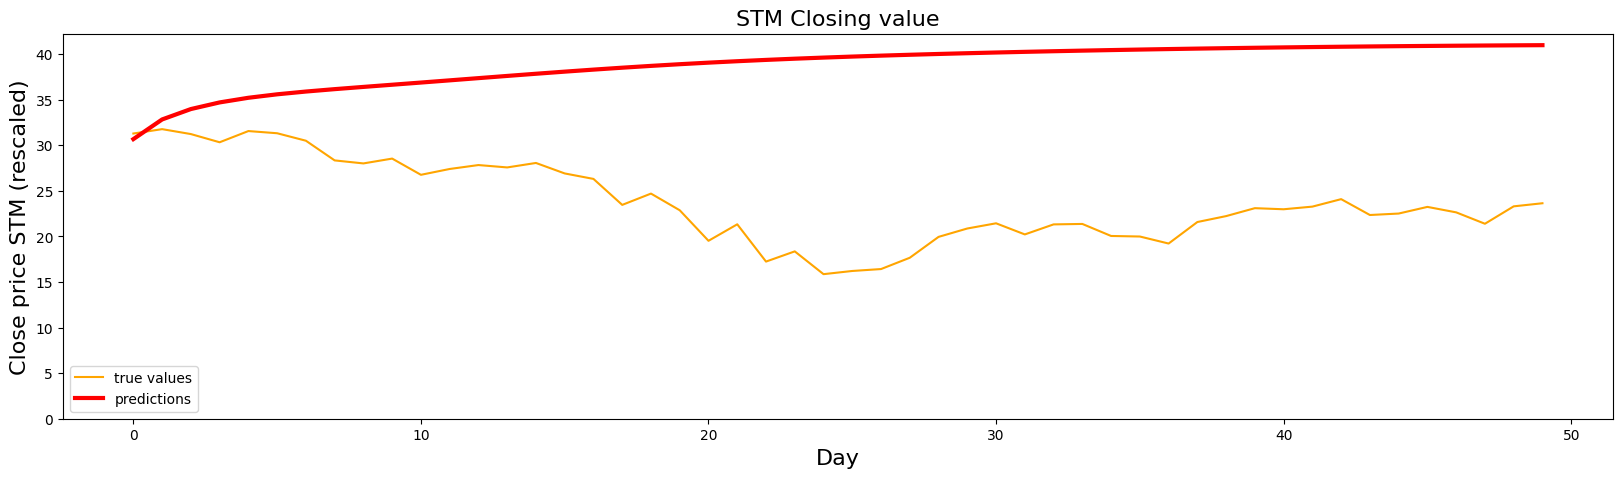

In [42]:
plt.figure(figsize=(20,5))
plt.plot(y_test_rev_scaled[10,:-1,3], c='orange',label='true values')
plt.plot(new_prediction_rev_scaled[10,:-1,3], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("Day", fontsize=16)
plt.ylabel("Close price STM (rescaled)", fontsize=16)
plt.title("STM Closing value", fontsize=16);
plt.ylim(0)

(0.0, 7705655.0)

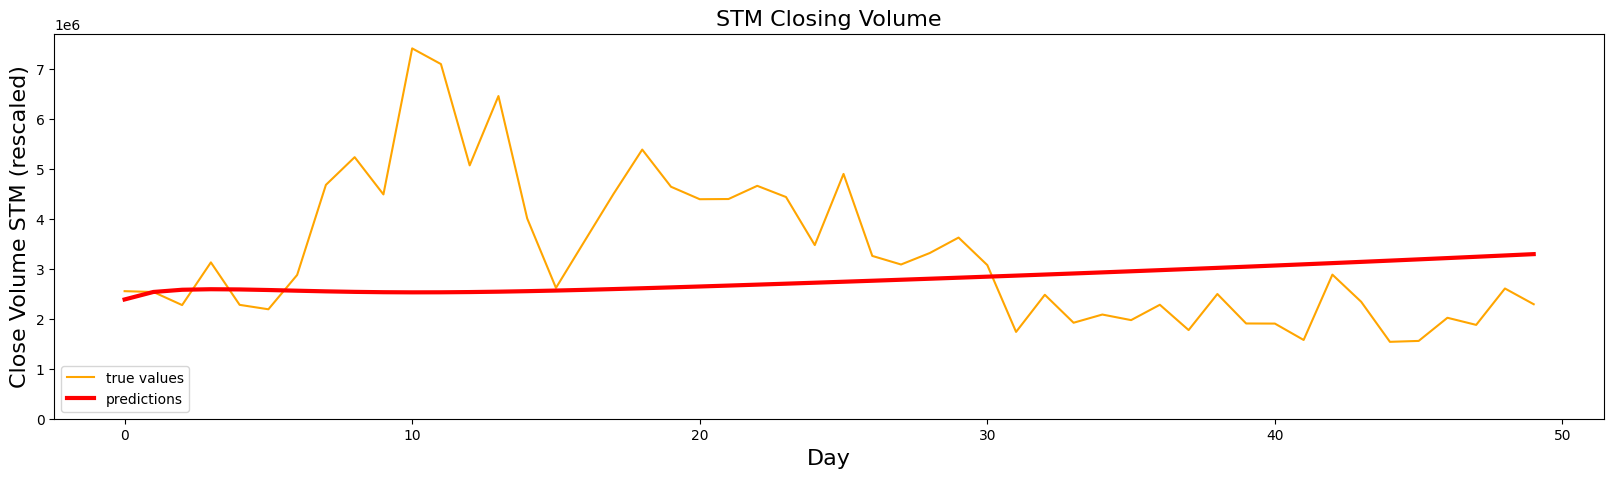

In [43]:
plt.figure(figsize=(20,5))
plt.plot(y_test_rev_scaled[10,:-1,5], c='orange',label='true values')
plt.plot(new_prediction_rev_scaled[10,:-1,5], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("Day", fontsize=16)
plt.ylabel("Close Volume STM (rescaled)", fontsize=16)
plt.title("STM Closing Volume", fontsize=16);
plt.ylim(0)

In [44]:
def trend_extractor(array, Choice):
  trend_array = np.array([])
  data_indices = {'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Adj Close': 4, 'Volume': 5}
  idx = data_indices[Choice]

  array = array[:,0:-1,idx]
  print("Array shape", array.shape)
  for i in array:
    if i[-1] > i[0]:
      trend = 1
    elif i[-1] < i[0]:
      trend = -1
    elif i[-1] == i[0]:
      trend = 0
    else:
      print("No comparison is made")
    trend_array = np.append(trend_array, trend)
  return trend_array

In [45]:
prediction_trend = trend_extractor(new_prediction_rev_scaled, Choice="Close")
y_test_trend = trend_extractor(y_test_rev_scaled, Choice="Close")

accuracy1 = np.mean(y_test_trend == prediction_trend)
print("Accuracy of Closing Price for 50 days prediction without Teacher Forcing is", accuracy1*100, "%")

Array shape (986, 50)
Array shape (986, 50)
Accuracy of Closing Price for 50 days prediction without Teacher Forcing is 68.86409736308316 %


In [46]:
  prediction_trend = trend_extractor(new_prediction_rev_scaled, Choice="Volume")
y_test_trend = trend_extractor(y_test_rev_scaled, Choice="Volume")

accuracy2 = np.mean(y_test_trend == prediction_trend)
print("Accuracy of Closing Price for 50 days prediction is without Teacher Forcing is", accuracy2*100, "%")

Array shape (986, 50)
Array shape (986, 50)
Accuracy of Closing Price for 50 days prediction is without Teacher Forcing is 50.20283975659229 %
